# Analysis of College Student Behaviors: Exploring Differences in Academic Performance, Sleep, and Lifestyle Factors

# Background

This is the second project for STAT 353, Statistical Methods I for Engineering. In this report, we analyse data pertaining to 10 research questions and documment the key findings and understandings. The data we use describes the sleeping patterns of college students.

## Research Questions

1.   Is there a significant difference in the average GPA between male and female college students?
2.   Is there a significant difference in the average number of early classes between the first two class years and other class years?
3.   Do students who identify as "larks" have significantly better cognitive skills (cognition z-score) compared to "owls"?
4.   Is there a significant difference in the average number of classes missed in a semester between students who had at least one early class (EarlyClass=1) and those who didn't (EarlyClass=0)?
5.   Is there a significant difference in the average happiness level between students with at least moderate depression and normal depression status?
6.   Is there a significant difference in average sleep quality scores between students who reported having at least one all-nighter (AllNighter=1) and those who didn't (AllNighter=0)?
7.   Do students who abstain from alcohol use have significantly better stress scores than those who report heavy alcohol use?
8.   Is there a significant difference in the average number of drinks per week between students of different genders?
9.   Is there a significant difference in the average weekday bedtime between students with high and low stress (Stress=High vs. Stress=Normal)?
10.   Is there a significant difference in the average hours of sleep on weekends between first two year students and other students?


# Task

We are tasked with addressing 10 research questions provided by the assignment description. This involved data analysis (using the techniques we've learned since chapter 6) and a summmamry of the key findings.

# Data

The data used for this project comes from a 2012 research paper created by [Onyper, Thacher, Gilbert, and Gradess](https://pubmed.ncbi.nlm.nih.gov/22390245/). The dataset hosted on [Lock5Stat.com](https://www.lock5stat.com/datapage3e.html) contains 253 observations with 27 columns of data. The data was obtained from college students who were assessed  using surveys, skills tests, and sleep diaries. The data tracks some basic information about each student in addition to their habits and sleeping data.

# Tools

To process and analyze data for this project, we use Google Collab to run Python notebook files. MatPlotLib, Pandas, SciPy, and NumPy are also used for graphing, data manipulation, and mathematical computation. We chose these technologies due to previous experience with them in machine learning projects.

# Get the Data

Before we get the data, we must import all the necessary libraries.

In [91]:
# @title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.stats.weightstats as sm

The following code will look for the data file in a local directory and download a new copy if it doesn't exist on the system yet.

In [92]:
# @title
from pathlib import Path
import urllib.request

def load_housing_data():
    filepath = Path("datasets/SleepStudy.csv")
    if not filepath.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://www.lock5stat.com/datasets3e/SleepStudy.csv"
        urllib.request.urlretrieve(url, filepath)
    return pd.read_csv(Path("datasets/SleepStudy.csv"))

default_dataset = load_housing_data()

Taking a look at the first few entries shows that the data was imported successfully!

In [93]:
# @title
default_dataset.head ()

,Gender,ClassYear,LarkOwl,NumEarlyClass,EarlyClass,GPA,ClassesMissed,CognitionZscore,PoorSleepQuality,DepressionScore,...,AlcoholUse,Drinks,WeekdayBed,WeekdayRise,WeekdaySleep,WeekendBed,WeekendRise,WeekendSleep,AverageSleep,AllNighter
0,0,4,Neither,0,0,3.60,0,-0.26,4,4,...,Moderate,10,25.75,8.70,7.70,25.75,9.50,5.88,7.18,0
1,0,4,Neither,2,1,3.24,0,1.39,6,1,...,Moderate,6,25.70,8.20,6.80,26.00,10.00,7.25,6.93,0
2,0,4,Owl,0,0,2.97,12,0.38,18,18,...,Light,3,27.44,6.55,3.00,28.00,12.59,10.09,5.02,0
3,0,1,Lark,5,1,3.76,0,1.39,9,1,...,Light,2,23.50,7.17,6.77,27.00,8.00,7.25,6.90,0
4,0,4,Owl,0,0,3.20,4,1.22,9,7,...,Moderate,4,25.90,8.67,6.09,23.75,9.50,7.00,6.35,0


We can also look at a list of columns.

In [94]:
# @title
default_dataset.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            253 non-null    int64  
 1   ClassYear         253 non-null    int64  
 2   LarkOwl           253 non-null    object 
 3   NumEarlyClass     253 non-null    int64  
 4   EarlyClass        253 non-null    int64  
 5   GPA               253 non-null    float64
 6   ClassesMissed     253 non-null    int64  
 7   CognitionZscore   253 non-null    float64
 8   PoorSleepQuality  253 non-null    int64  
 9   DepressionScore   253 non-null    int64  
 10  AnxietyScore      253 non-null    int64  
 11  StressScore       253 non-null    int64  
 12  DepressionStatus  253 non-null    object 
 13  AnxietyStatus     253 non-null    object 
 14  Stress            253 non-null    object 
 15  DASScore          253 non-null    int64  
 16  Happiness         253 non-null    int64  
 1

This shows that none of the columns are missing any data, which makes analysis easier. With the data loaded into memory, we are now ready to begin analysis.

# Analysis

The following function will be used throughout the notebook to calculate two-sample t-tests and confidence intervals.

In [95]:
def calcTTestStats (group1, group2):
  test = sm.ttest_ind(group1, group2, usevar='unequal')
  ci = sm.CompareMeans(sm.DescrStatsW(group1), sm.DescrStatsW(group2)).tconfint_diff()
  ci_formatted = (f"{ci[0]:.5f}", f"{ci[1]:.5f}")

  print("T-statistic:", test[0])
  print("P-value:", test[1])
  print(f"95% Confidence Interval for the difference in means: {ci_formatted}")
  print ()

  alpha = 0.05
  p_value = test[1]
  if p_value < alpha:
      print("Null hypothesis rejected. There is a significant difference in means.")
  else:
      print("Null hypothesis NOT rejected. There is no significant difference in means.")

## Is there a significant difference in the average GPA between male and female college students?

We begin by separating the GPA column based on the gender of each person.

In [96]:
# @title
male_gpa = default_dataset[default_dataset['Gender'] == 1]['GPA']
female_gpa = default_dataset[default_dataset['Gender'] == 0]['GPA']

Next, we observe the descriptions of each subset of data. We can see that the difference between their overall means is about 0.20, with female students having the higher overall mean.

In [97]:
# @title
print ("=====Male GPA=====")
print (male_gpa.describe ())
print ()

print ("=====Female GPA=====")
print (female_gpa.describe ())

=====Male GPA=====
count    102.000000
mean       3.123725
std        0.417643
min        2.000000
25%        2.800000
50%        3.150000
75%        3.400000
max        4.000000
Name: GPA, dtype: float64

=====Female GPA=====
count    151.000000
mean       3.324901
std        0.375123
min        2.000000
25%        3.105000
50%        3.300000
75%        3.600000
max        4.000000
Name: GPA, dtype: float64


The following figure shows the boxplots for each subset of data. They both range from 2.0 to 4.0, but the male boxplot shows that most of the male data lies between 2.4 and 4.0.

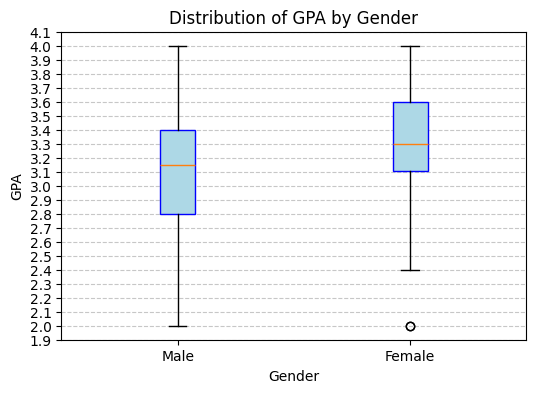

In [98]:
# @title
plt.figure(figsize=(6, 4))
plt.boxplot(
    [male_gpa, female_gpa],
    labels=['Male', 'Female'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
)
plt.title('Distribution of GPA by Gender')
plt.xlabel('Gender')
plt.ylabel('GPA')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.locator_params(axis='y', nbins=30)
plt.show()

Now we perform a 2-sample t-test to determine whether there is a significant difference in the means. The below results show that the null hypothesis was rejected, suggesting there is in fact a significant difference in GPA.

In [99]:
calcTTestStats (male_gpa, female_gpa)

T-statistic: -3.913916462547876
P-value: 0.0001242980008452469
95% Confidence Interval for the difference in means: ('-0.30032', '-0.10203')

Null hypothesis rejected. There is a significant difference in means.


These results suggest that there is a significant difference in average GPA between male and female students. This difference might be influenced by various factors, such as their typical choice in majors, support networks, gendered peer influences, or grading bias. However, further investigation is required to determine causation.

## Is there a significant difference in the average number of early classes between the first two class years and other class years?

We begin by separating the column containing the number of early classes. We split it into the lower class students (years 1-2) and the upper class students (years 3-4).

In [100]:
# @title
lower_class = default_dataset[default_dataset['ClassYear'].isin([1, 2])]['NumEarlyClass']
upper_class = default_dataset[default_dataset['ClassYear'].isin([3, 4])]['NumEarlyClass']

Next, we observe the descriptions of each subset of data. We can see that the difference between their overall means is about 0.76, with lower classmen having the higher average.

In [101]:
# @title
print ("=====Lower Classmen Early Classes=====")
print (lower_class.describe ())
print ()

print ("=====Upper Classmen Early Classes=====")
print (upper_class.describe ())

=====Lower Classmen Early Classes=====
count    142.000000
mean       2.070423
std        1.657341
min        0.000000
25%        0.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: NumEarlyClass, dtype: float64

=====Upper Classmen Early Classes=====
count    111.000000
mean       1.306306
std        1.248947
min        0.000000
25%        0.000000
50%        2.000000
75%        2.000000
max        5.000000
Name: NumEarlyClass, dtype: float64


The following figure shows the boxplots for each subset of data. They both have similar ranges, although the second and third quartiles for the upper classmen are equal. It makes up for this by having a much longer upper whisker.

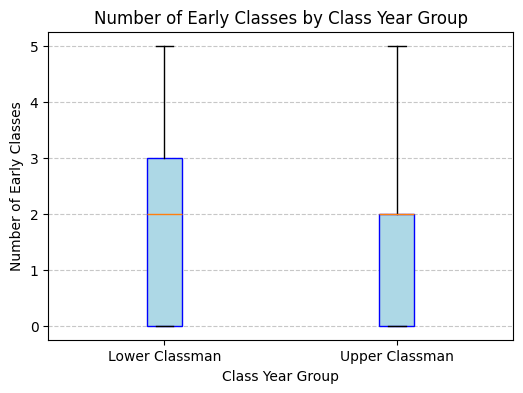

In [102]:
# @title
plt.figure(figsize=(6, 4))
plt.boxplot(
    [lower_class, upper_class],
    labels=['Lower Classman', 'Upper Classman'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
)
plt.title('Number of Early Classes by Class Year Group')
plt.xlabel('Class Year Group')
plt.ylabel('Number of Early Classes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Now we perform a 2-sample t-test to determine whether there is a significant difference in the means. The below results show that the null hypothesis was rejected, suggesting there is in fact a significant difference in the number of early classes taken.

In [103]:
calcTTestStats (lower_class, upper_class)

T-statistic: 4.181284304075919
P-value: 4.009355722080891e-05
95% Confidence Interval for the difference in means: ('0.39179', '1.13644')

Null hypothesis rejected. There is a significant difference in means.


These results suggest that students in the latter half of college take fewer early classes. Although the data doesn't indicate this for sure, one possible explanation is that students who are farther in their major may have more options for courses they can take. They can choose to postpone classes until they are available at a more convenient time, unlike new students who may be shoehorned into taking specific classes to fulfill prerequisites. Another possible explanation  is that the universit(ies) the data was collected from may schedule lower level classes earlier in the day. Additional data would help confirm these explanations.

## Do students who identify as "larks" have significantly better cognitive skills (cognition z-score) compared to "owls"?

We begin by separating the cognition z-score column based on whether the student is a lark (early riser) or owl (late nighter). Students who aren't either will not be considered.

In [104]:
# @title
larks = default_dataset[default_dataset['LarkOwl'] == 'Lark']['CognitionZscore']
owls = default_dataset[default_dataset['LarkOwl'] == 'Owl']['CognitionZscore']

Next, we observe the descriptions of each subset of data. We can see that the difference between their overall means is about 0.13, with larks having the higher average.

In [105]:
# @title
print ("=====Larks Cognition Z-score=====")
print (larks.describe ())
print ()

print ("=====Owls Cognition Z-score=====")
print (owls.describe ())

=====Larks Cognition Z-score=====
count    41.000000
mean      0.090244
std       0.829568
min      -1.620000
25%      -0.420000
50%       0.120000
75%       0.760000
max       1.890000
Name: CognitionZscore, dtype: float64

=====Owls Cognition Z-score=====
count    49.000000
mean     -0.038367
std       0.652742
min      -1.450000
25%      -0.510000
50%      -0.010000
75%       0.480000
max       1.220000
Name: CognitionZscore, dtype: float64


The following figure shows the boxplots for each subset of data. The owls have a slightly smaller IQR and a smaller range overall.

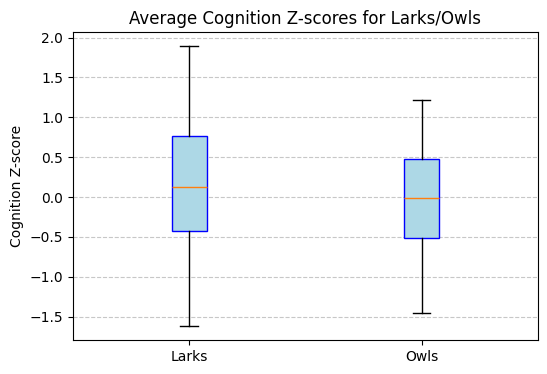

In [106]:
# @title
plt.figure(figsize=(6, 4))
plt.boxplot(
    [larks, owls],
    labels=['Larks', 'Owls'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
)
plt.title('Average Cognition Z-scores for Larks/Owls')
plt.ylabel('Cognition Z-score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Now we perform a 2-sample t-test to determine whether there is a significant difference in the means. The below results show that the null hypothesis was **not** rejected, suggesting there is not a significant difference in the average z-score between owls and larks.

In [107]:
calcTTestStats (larks, owls)

T-statistic: 0.8057063240065147
P-value: 0.4229482300999131
95% Confidence Interval for the difference in means: ('-0.18197', '0.43919')

Null hypothesis NOT rejected. There is no significant difference in means.


While larks had a slightly higher mean cognition z-score, the results do not provide strong evidence of a significant difference. Future research might find better results by exploring factors such as sleep quality and duration.

## Is there a significant difference in the average number of classes missed in a semester between students who had at least one early class (EarlyClass=1) and those who didn't (EarlyClass=0)?

We begin by separating the classes missed column based on whether the student has any early classes.

In [108]:
# @title
early_class = default_dataset[default_dataset['EarlyClass'] == 1]['ClassesMissed']
no_early_class = default_dataset[default_dataset['EarlyClass'] == 0]['ClassesMissed']

Next, we observe the descriptions of each subset of data. We can see that the difference between their overall means is about 0.66. The students without any early classes have the highest mean of the pair.

In [109]:
# @title
print ("=====Early Class Students Classes Missed=====")
print (early_class.describe ())
print ()

print ("=====Non Early Class Students Classes Missed=====")
print (no_early_class.describe ())

=====Early Class Students Classes Missed=====
count    168.000000
mean       1.988095
std        3.101068
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       20.000000
Name: ClassesMissed, dtype: float64

=====Non Early Class Students Classes Missed=====
count    85.000000
mean      2.647059
std       3.476814
min       0.000000
25%       0.000000
50%       2.000000
75%       4.000000
max      20.000000
Name: ClassesMissed, dtype: float64


The following figure shows the boxplots for each subset of data. Both plots have similar ranges if we include outliers. Without them, it is clear that the plot for students who take early classes is much more narrow and slightly skewed.

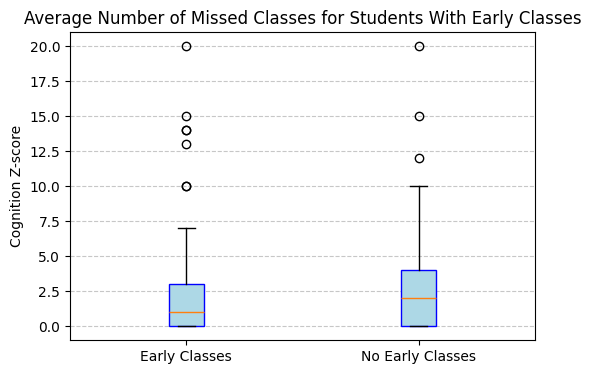

In [110]:
# @title
plt.figure(figsize=(6, 4))
plt.boxplot(
    [early_class, no_early_class],
    labels=['Early Classes', 'No Early Classes'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
)
plt.title('Average Number of Missed Classes for Students With Early Classes')
plt.ylabel('Cognition Z-score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Now we perform a 2-sample t-test to determine whether there is a significant difference in the means. The below results show that the null hypothesis was not rejected, suggesting there is not a significant difference in the average number of missed classes for students with/without early classes.

In [111]:
calcTTestStats (early_class, no_early_class)

T-statistic: -1.4754941477436887
P-value: 0.14213766814478054
95% Confidence Interval for the difference in means: ('-1.50614', '0.18821')

Null hypothesis NOT rejected. There is no significant difference in means.


The results do not show a significant difference in the number of classes missed based on having early classes. Other potential factors, such as GPA, student sleep patterns, or overall course load, may be worth exploring instead.

## Is there a significant difference in the average happiness level between students with at least moderate depression and normal depression status?

We begin by separating the happiness column based on whether the student has at least moderate depression status.

In [112]:
# @title
no_depression = default_dataset[default_dataset['DepressionStatus'] == 'normal']['Happiness']
yes_depression = default_dataset[default_dataset['DepressionStatus'].isin(['moderate', 'severe'])]['Happiness']

Next, we observe the descriptions of each subset of data. We can see that the difference between their overall means is about 5.44. The students with normal depression status have the highest mean of the pair.

In [113]:
# @title
print ("=====No Depression Happiness Levels=====")
print (no_depression.describe ())
print ()

print ("=====With Depression Happiness Levels=====")
print (yes_depression.describe ())

=====No Depression Happiness Levels=====
count    209.000000
mean      27.057416
std        4.884882
min        0.000000
25%       25.000000
50%       28.000000
75%       30.000000
max       35.000000
Name: Happiness, dtype: float64

=====With Depression Happiness Levels=====
count    44.000000
mean     21.613636
std       6.004711
min       5.000000
25%      17.000000
50%      24.000000
75%      26.000000
max      29.000000
Name: Happiness, dtype: float64


The following figure shows the boxplots for each subset of data. The boxplot for students without depression has a shorter IQR but has several outliers below the plot, including an extreme outlier at 0. The boxplot for students with at least moderate depression has a greater skew and IQR. However, its maximum value is lower than the other plot.

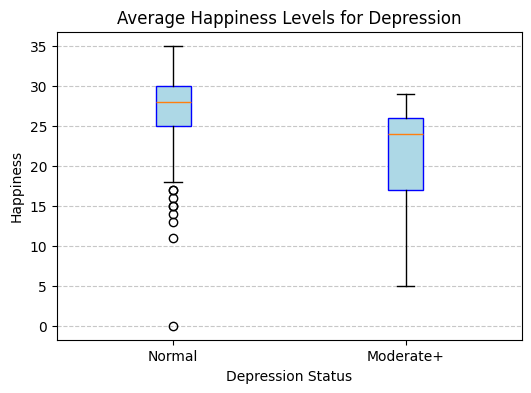

In [114]:
# @title
plt.figure(figsize=(6, 4))
plt.boxplot(
    [no_depression, yes_depression],
    labels=['Normal', 'Moderate+'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
)
plt.title('Average Happiness Levels for Depression')
plt.xlabel('Depression Status')
plt.ylabel('Happiness')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Now we perform a 2-sample t-test to determine whether there is a significant difference in the means. The below results show that the null hypothesis was not rejected, suggesting there is a significant difference in the average happiness between students with normal/at least moderate depression status.

In [115]:
calcTTestStats (no_depression, yes_depression)

T-statistic: 5.633922859753451
P-value: 6.056558828371944e-07
95% Confidence Interval for the difference in means: ('3.77965', '7.10791')

Null hypothesis rejected. There is a significant difference in means.


These findings suggest a strong association between depression and reduced happiness. This aligns with boxplot observations showing lower happiness among students with depression. Future research should attempt to find the major contributing factors to a student's depression status.

## Is there a significant difference in average sleep quality scores between students who reported having at least one all-nighter (AllNighter=1) and those who didn't (AllNighter=0)?

We begin by separating the poor sleep quality column based on whether the student has pulled an all-nighter.

In [116]:
# @title
all_nighter_group = default_dataset[default_dataset['AllNighter'] == 1]['PoorSleepQuality']
no_all_nighter_group = default_dataset[default_dataset['AllNighter'] == 0]['PoorSleepQuality']

Next, we observe the descriptions of each subset of data. We can see that the difference between their overall means is about 0.89, with students who've pulled all-nighters having a higher average (higher values indicate worse sleep quality).

In [117]:
# @title
print ("=====All-Nighter Sleep Quality=====")
print (all_nighter_group.describe ())
print ()

print ("=====Non-All-Nighter Sleep Quality=====")
print (no_all_nighter_group.describe ())

=====All-Nighter Sleep Quality=====
count    34.000000
mean      7.029412
std       2.822907
min       2.000000
25%       5.000000
50%       7.000000
75%       9.000000
max      12.000000
Name: PoorSleepQuality, dtype: float64

=====Non-All-Nighter Sleep Quality=====
count    219.000000
mean       6.136986
std        2.922462
min        1.000000
25%        4.000000
50%        6.000000
75%        8.000000
max       18.000000
Name: PoorSleepQuality, dtype: float64


The following figure shows the boxplots for each subset of data. Both have similar IQRs, but the non-all-nighters have a greater range and more outliers. That boxplot also has greater/smaller maximum/minimum values.

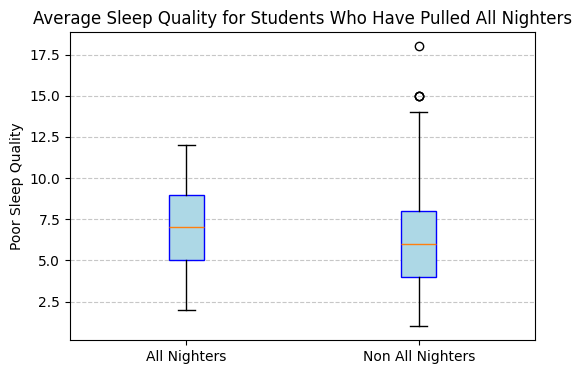

In [118]:
# @title
plt.figure(figsize=(6, 4))
plt.boxplot(
    [all_nighter_group, no_all_nighter_group],
    labels=['All Nighters', 'Non All Nighters'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
)
plt.title('Average Sleep Quality for Students Who Have Pulled All Nighters')
plt.ylabel('Poor Sleep Quality')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Now we perform a 2-sample t-test to determine whether there is a significant difference in the means. The below results show that the null hypothesis was not rejected, suggesting there is not a significant difference in the average sleep quality between students who have/haven't pulled all-nighters.

In [119]:
calcTTestStats (all_nighter_group, no_all_nighter_group)

T-statistic: 1.7068369884139776
P-value: 0.09478990893459473
95% Confidence Interval for the difference in means: ('-0.16384', '1.94869')

Null hypothesis NOT rejected. There is no significant difference in means.


The results do not indicate a significant difference in sleep quality based on all-nighter status. However, it may be worth revisiting this question with more detailed data. The current all-nighter column is binary and only tracks whether the student had an all-nighter in the last semester. A more useful pattern may emerge if we analyze the data again with a quantitative value instead. Other factors, such as the students' depression, anxiety, and stress levels may be more relevant.

## Do students who abstain from alcohol use have significantly better stress scores than those who report heavy alcohol use?

We begin by separating the stress score column based on whether the student is a heavy drinker or non-drinker. Students who aren't either will not be considered.

In [120]:
# @title
abstain_group = default_dataset[default_dataset['AlcoholUse'] == 'Abstain']['StressScore']
heavy_group = default_dataset[default_dataset['AlcoholUse'] == 'Heavy']['StressScore']

Next, we observe the descriptions of each subset of data. We can see that the difference between their overall means is about 1.47, with heavy alcohol users having the higher average.

In [121]:
# @title
print ("=====Abstained From Alcohol Stress Scores=====")
print (abstain_group.describe ())
print ()

print ("=====Heavy Use of Alcohol Stress Scores=====")
print (heavy_group.describe ())

=====Abstained From Alcohol Stress Scores=====
count    34.000000
mean      8.970588
std       7.581818
min       0.000000
25%       3.000000
50%       7.000000
75%      12.750000
max      28.000000
Name: StressScore, dtype: float64

=====Heavy Use of Alcohol Stress Scores=====
count    16.000000
mean     10.437500
std       7.797168
min       0.000000
25%       4.500000
50%      10.000000
75%      16.000000
max      27.000000
Name: StressScore, dtype: float64


The following figure shows the boxplots for each subset of data. The boxplot for heavy alcohol users has a higher IQR. It also has a higher range if you disregard the outlier from the other plot. Both plots have much longer upper whiskers than lower whiskers, indicating that the data for both groups is positively skewed.

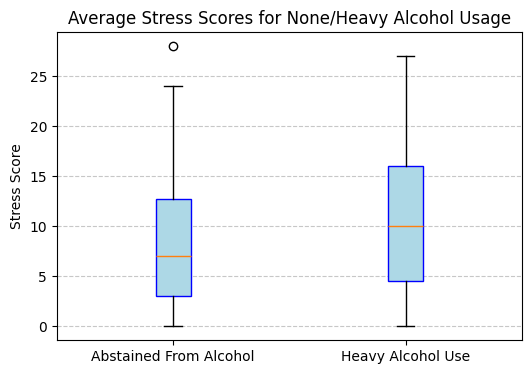

In [122]:
# @title
plt.figure(figsize=(6, 4))
plt.boxplot(
    [abstain_group, heavy_group],
    labels=['Abstained From Alcohol', 'Heavy Alcohol Use'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
)
plt.title('Average Stress Scores for None/Heavy Alcohol Usage')
plt.ylabel('Stress Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Now we perform a 2-sample t-test to determine whether there is a significant difference in the means. The below results show that the null hypothesis was not rejected, suggesting there is not a significant difference in the average stress scores between heavy drinkers and non-drinkers.

In [123]:
calcTTestStats (abstain_group, heavy_group)

T-statistic: -0.6260373584796187
P-value: 0.5362324194498913
95% Confidence Interval for the difference in means: ('-6.12993', '3.19610')

Null hypothesis NOT rejected. There is no significant difference in means.


The results do not provide strong evidence of a significant difference in stress scores between abstainers and heavy drinkers. Investigating other factors, like GPA, depression score, and sleep quality, may yield more insights.

## Is there a significant difference in the average number of drinks per week between students of different genders?

We begin by separating the number of drinks column based on the gender of the student.

In [124]:
# @title
male_drinks = default_dataset.loc[default_dataset['Gender'] == 1, 'Drinks']
female_drinks = default_dataset.loc[default_dataset['Gender'] == 0, 'Drinks']

Next, we observe the descriptions of each subset of data. We can see that the difference between their overall means is about 3.30, with males having a higher average.

In [125]:
# @title
print ("=====Male Number of Drinks=====")
print (male_drinks.describe ())
print ()

print ("=====Female Number of Drinks=====")
print (female_drinks.describe ())

=====Male Number of Drinks=====
count    102.000000
mean       7.539216
std        4.928542
min        0.000000
25%        4.250000
50%        8.000000
75%       10.000000
max       24.000000
Name: Drinks, dtype: float64

=====Female Number of Drinks=====
count    151.000000
mean       4.238411
std        2.719580
min        0.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       12.000000
Name: Drinks, dtype: float64


The following figure shows the boxplots for each subset of data. The boxplot for males shows a greater range and more outliers. It also has a higher maximum value, although it shares its minimum value with the female boxplot.

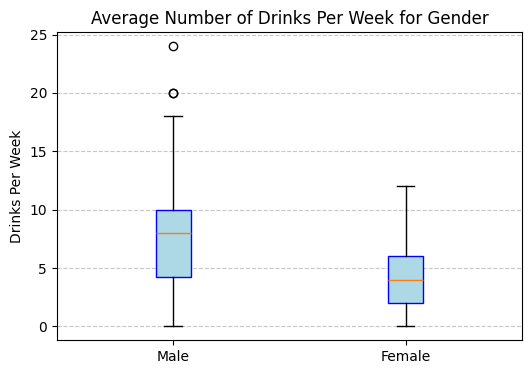

In [126]:
# @title
plt.figure(figsize=(6, 4))
plt.boxplot(
    [male_drinks, female_drinks],
    labels=['Male', 'Female'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
)
plt.title('Average Number of Drinks Per Week for Gender')
plt.ylabel('Drinks Per Week')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Now we perform a 2-sample t-test to determine whether there is a significant difference in the means. The below results show that the null hypothesis was rejected, suggesting there is a significant difference in the average number of drinks per week for males/females.

In [127]:
calcTTestStats (male_drinks, female_drinks)

T-statistic: 6.160070148632675
P-value: 7.0017434376785415e-09
95% Confidence Interval for the difference in means: ('2.34982', '4.25179')

Null hypothesis rejected. There is a significant difference in means.


The results suggest that males generally consume more alcohol than females. The male boxplots also indicate a wider range of drinking habits compared to female plot. This could reflect a variety of social or cultural factors that warrant further investigation.

## Is there a significant difference in the average weekday bedtime between students with high and low stress (Stress=High vs. Stress=Normal)?

We begin by separating the weekday bedtime column based on whether the student has high or low stress.

In [128]:
# @title
high_stress_bedtime = default_dataset.loc[default_dataset['Stress'] == 'high', 'WeekdayBed']
normal_stress_bedtime = default_dataset.loc[default_dataset['Stress'] == 'normal', 'WeekdayBed']

Next, we observe the descriptions of each subset of data. We can see that the difference between their overall means is about 0.17, with the low stress students having the higher average.

In [129]:
# @title
print ("=====High Stress Weekly Bedtime=====")
print (high_stress_bedtime.describe ())
print ()

print ("=====Low Stress Weekly Bedtime=====")
print (normal_stress_bedtime.describe ())

=====High Stress Weekly Bedtime=====
count    56.000000
mean     24.715000
std       1.052759
min      22.830000
25%      24.100000
50%      24.700000
75%      25.217500
max      26.800000
Name: WeekdayBed, dtype: float64

=====Low Stress Weekly Bedtime=====
count    197.000000
mean      24.885431
std        1.027793
min       21.800000
25%       24.200000
50%       24.900000
75%       25.570000
max       29.100000
Name: WeekdayBed, dtype: float64


The following figure shows the boxplots for each subset of data. The boxplot for the low-stress students has a greater range and more outliers. It also has greater/smaller maximum/minimum values compared to the boxplot for high stress students.

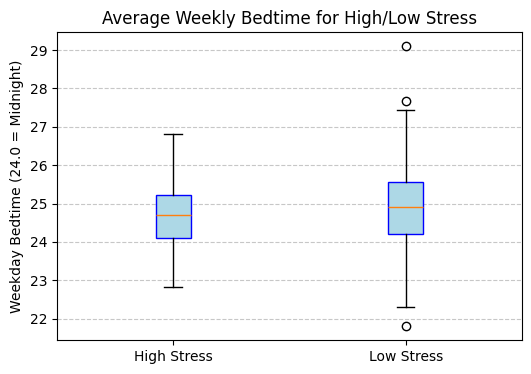

In [130]:
# @title
plt.figure(figsize=(6, 4))
plt.boxplot(
    [high_stress_bedtime, normal_stress_bedtime],
    labels=['High Stress', 'Low Stress'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
)
plt.title('Average Weekly Bedtime for High/Low Stress')
plt.ylabel('Weekday Bedtime (24.0 = Midnight)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Now we perform a 2-sample t-test to determine whether there is a significant difference in the means. The below results show that the null hypothesis was not rejected, suggesting there is not a significant difference in the weekday betime for high/low stress students.

In [131]:
calcTTestStats (high_stress_bedtime, normal_stress_bedtime)

T-statistic: -1.0746130058886139
P-value: 0.2855177391067136
95% Confidence Interval for the difference in means: ('-0.47862', '0.13775')

Null hypothesis NOT rejected. There is no significant difference in means.


The results do not indicate a significant difference in weekday bedtime based on stress levels. Instead, it may be affected by other factors such as personal habits, whether they have early classes, and their social activities.

## Is there a significant difference in the average hours of sleep on weekends between first two year students and other students?

We begin by separating the column containing the amount of weekend sleep each student gets. We split it into the lower class students (years 1-2) and the upper class students (years 3-4).

In [132]:
# @title
lower_class_sleep = default_dataset[default_dataset['ClassYear'].isin([1, 2])]['WeekendSleep']
upper_class_sleep = default_dataset[default_dataset['ClassYear'].isin([3, 4])]['WeekendSleep']

Next, we observe the descriptions of each subset of data. We can see that the difference between their overall means is about 0.0083, with upper classmen having the higher average.

In [133]:
# @title
print ("=====Lower Class Hours of Weekend Sleep=====")
print (lower_class_sleep.describe ())
print ()

print ("=====Upper Class Hours of Weekend Sleep=====")
print (upper_class_sleep.describe ())

=====Lower Class Hours of Weekend Sleep=====
count    142.000000
mean       8.213592
std        1.374464
min        4.000000
25%        7.250000
50%        8.250000
75%        9.437500
max       11.000000
Name: WeekendSleep, dtype: float64

=====Upper Class Hours of Weekend Sleep=====
count    111.000000
mean       8.221892
std        1.363108
min        4.380000
25%        7.270000
50%        8.250000
75%        9.065000
max       12.750000
Name: WeekendSleep, dtype: float64


The following figure shows the boxplots for each subset of data. The boxplot for upper class students has a couple of outliers and a greater maximum value. However, the boxplot for the lower classman shows a slightly larger IQR and a lower minimum value.

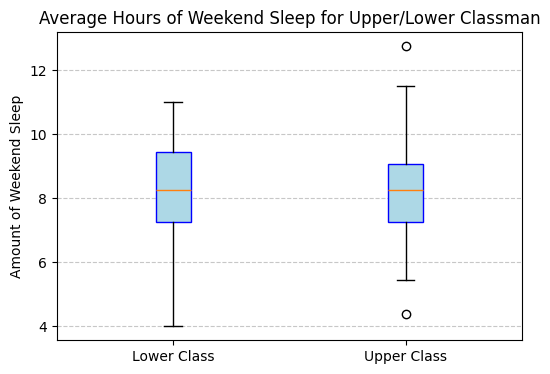

In [134]:
# @title
plt.figure(figsize=(6, 4))
plt.boxplot(
    [lower_class_sleep, upper_class_sleep],
    labels=['Lower Class', 'Upper Class'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
)
plt.title('Average Hours of Weekend Sleep for Upper/Lower Classman')
plt.ylabel('Amount of Weekend Sleep')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Now we perform a 2-sample t-test to determine whether there is a significant difference in the means. The below results show that the null hypothesis was not rejected, suggesting there is not a significant difference in the average amount of weekend sleep between lower/upper classmen.

In [135]:
calcTTestStats (lower_class_sleep, upper_class_sleep)

T-statistic: -0.04788758907862904
P-value: 0.9618460981714023
95% Confidence Interval for the difference in means: ('-0.35001', '0.33341')

Null hypothesis NOT rejected. There is no significant difference in means.


The results suggest no significant difference in weekend sleep hours between lower and upper-class students. Other factors may have a greater impact, such as the amount of weekend sleep may be more affected by extracurricular  activities, academic workload, depression score, or anxiety score.

# Summary

This report summarizes findings from a series of independent 2-sample t-tests that analyze various factors related to college student behaviors, feelings, and academics. Below is a summary of our findings and interpretations for each question:


1.   **GPA and Gender**: There is a significant difference in average GPA between male and female college students, with females having a higher mean GPA (3.32 vs 3.12).
2.   **Early Classes and Class Year**: Lower classmen (years 1-2) take significantly more early classes than upper classmen (years 3-4), with a difference in means of about 0.76.
3.   **Cognitive Skills and Chronotype**: No significant difference was found in cognitive skills (measured by cognition z-score) between students who identify as "larks" (early risers) and "owls" (night owls).
4.   **Missed Classes and Early Classes**: There is no significant difference in the average number of classes missed between students who had at least one early class and those who didn't.
5.   **Happiness and Depression**: Students with at least moderate depression status have significantly lower happiness levels compared to those with normal depression status, with a difference in means of about 5.44.
6.   **Sleep Quality and All-Nighters**: No significant difference was found in average sleep quality scores between students who reported having at least one all-nighter and those who didn't.
7.   **Stress and Alcohol Use**: There is no significant difference in stress scores between students who abstain from alcohol and those who report heavy alcohol use.
8.   **Alcohol Consumption and Gender**: Male students consume significantly more drinks per week on average compared to female students, with a difference of about 3.30 drinks.
9.   **Weekday Bedtime and Stress**: There is no significant difference in average weekday bedtime between students with high and low stress levels.
10.   **Weekend Sleep Duration and Class Year**: No significant difference was found in the average hours of sleep on weekends between first two-year students and other students.


Overall, this project was insightful for understanding the relationships between lifestyle choices, sleep, and academics. This information may be useful for creating policy recommendations at universities across the country to improve the performance and quality of life for their students. It may also serve as a basis for further research into the other factors affecting student health and performance.

# References

Lock, R., Lock, P., Morgan, K., Lock, E., & Lock, D. (2020). *SleepStudy* [Dataset]. https://www.lock5stat.com/datapage3e.html

Lock, R., Lock, P., Morgan, K., Lock, E., & Lock, D. (2020). *Dataset documentaton for the third edition of “Statistics: UnLocking the Power of Data.”* Wiley. https://www.lock5stat.com/datasets3e/Lock5DataGuide3e.pdf

Onyper, S. V., Thacher, P. V., Gilbert, J. W., & Gradess, S. G. (2012). Class start times, sleep, and academic performance in college: a path analysis. Chronobiology international, 29(3), 318–335. https://doi.org/10.3109/07420528.2012.655868